1. 用简单的网络(Pytorch CPU版本)训练cifar10数据集，得到53%左右的准确率，并保存模型为cifar10.pth
2. 加载训练过的cifar10.pth模型，并剪枝，稀疏度设置为50%，保存模型为cifar10_50%.pth
3. 加载cifar10_50%.pth模型，验证准确率，发现有所下降，再一次进行剪枝，这一次设置稀疏度为80%，保存模型为cifar10_80%.pth
4. 加载cifar10_80%.pth模型，验证准确率，发现进一步下降
解决准确率下降的办法就是训练+剪枝+训练+剪枝，不断循环

In [1]:
%matplotlib inline

In [2]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn.utils.prune as prune

# 设置transform, 用于对数据进行转换

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# 加载训练集和测试集，同时进行shuffle, batch_size, transform等设置

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# 类别名称

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

# 训练集图片可视化

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

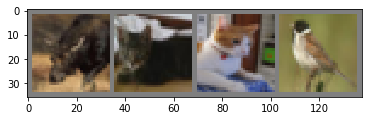

 deer   cat   cat  bird


In [8]:
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

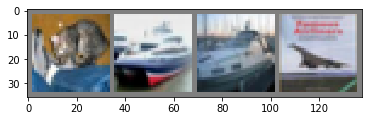

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 定义网络结构

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# 加载训练过的模型

注意每次剪枝之后，这个地方的模型name要改

In [11]:
PATH = './cifar10.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# 在测试集上验证模型的准确率

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


# 收集要prune的模块

In [13]:
parameters_to_prune = []

In [14]:
for name, module in net.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        parameters_to_prune.append((module, 'weight'))
    elif isinstance(module, torch.nn.Linear):
        parameters_to_prune.append((module, 'weight'))

In [15]:
parameters_to_prune

[(Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)), 'weight'),
 (Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)), 'weight'),
 (Linear(in_features=400, out_features=120, bias=True), 'weight'),
 (Linear(in_features=120, out_features=84, bias=True), 'weight'),
 (Linear(in_features=84, out_features=10, bias=True), 'weight')]

In [16]:
parameter_to_prune = tuple(parameters_to_prune)

# 进行全局prune

每次剪枝的时候要注意这里的稀疏度设置

In [17]:
prune.global_unstructured(parameter_to_prune,
                         pruning_method=prune.L1Unstructured,
                         amount=0.5)

In [18]:
print(list(module.named_parameters()))

[('bias', Parameter containing:
tensor([-0.3127, -0.5018, -0.0176,  0.3172,  0.3957, -0.1549,  0.1700, -0.4057,
         0.5314, -0.2936], requires_grad=True)), ('weight_orig', Parameter containing:
tensor([[ 0.1131, -0.0956,  0.0694,  0.1056,  0.0912, -0.1865, -0.0801, -0.0786,
          0.0307,  0.2390,  0.1167, -0.0332,  0.0715,  0.0058,  0.2710,  0.0161,
          0.1337, -0.0602,  0.0259, -0.1307, -0.1004,  0.1276, -0.0953,  0.2187,
          0.0805, -0.0107, -0.0529, -0.0437, -0.2305,  0.1482,  0.1998, -0.0290,
         -0.0852, -0.0250,  0.2457,  0.0695, -0.2443, -0.1650, -0.0120, -0.1354,
         -0.0635, -0.1189,  0.1392, -0.0949, -0.1511,  0.0354,  0.0305, -0.1015,
          0.0361, -0.0133, -0.1316,  0.2775, -0.2309,  0.2435, -0.0716,  0.0491,
          0.1291, -0.2240, -0.1170,  0.0193,  0.1302,  0.0168, -0.0805,  0.1051,
         -0.1192, -0.0886, -0.1093, -0.1193, -0.0256,  0.1999, -0.0675,  0.0771,
          0.2163, -0.1258, -0.0149, -0.0022, -0.0908, -0.0279,  0.0796, 

In [19]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
         1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
         1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 

# 保存模型前要prune.remove

In [20]:
for module, name in parameter_to_prune:
    prune.remove(module, name)

In [21]:
print(list(module.named_parameters()))

[('bias', Parameter containing:
tensor([-0.3127, -0.5018, -0.0176,  0.3172,  0.3957, -0.1549,  0.1700, -0.4057,
         0.5314, -0.2936], requires_grad=True)), ('weight', Parameter containing:
tensor([[ 0.1131, -0.0956,  0.0694,  0.1056,  0.0912, -0.1865, -0.0801, -0.0786,
          0.0000,  0.2390,  0.1167, -0.0332,  0.0715,  0.0000,  0.2710,  0.0000,
          0.1337, -0.0602,  0.0000, -0.1307, -0.1004,  0.1276, -0.0953,  0.2187,
          0.0805, -0.0000, -0.0529, -0.0437, -0.2305,  0.1482,  0.1998, -0.0000,
         -0.0852, -0.0000,  0.2457,  0.0695, -0.2443, -0.1650, -0.0000, -0.1354,
         -0.0635, -0.1189,  0.1392, -0.0949, -0.1511,  0.0354,  0.0000, -0.1015,
          0.0361, -0.0000, -0.1316,  0.2775, -0.2309,  0.2435, -0.0716,  0.0491,
          0.1291, -0.2240, -0.1170,  0.0000,  0.1302,  0.0000, -0.0805,  0.1051,
         -0.1192, -0.0886, -0.1093, -0.1193, -0.0000,  0.1999, -0.0675,  0.0771,
          0.2163, -0.1258, -0.0000, -0.0000, -0.0908, -0.0000,  0.0796, -0.12

In [22]:
print(list(module.named_buffers()))

[]


每次保存模型的时候，这里的模型name要改

In [23]:
torch.save(net.state_dict(), 'cifar10_50%.pth')